HuggingFace로 두 문장의 논리적 모순 분류하기

## 1. dataset 준비

In [1]:
import random
import evaluate
import numpy as np
import pandas as pd

from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from collections import defaultdict
import matplotlib.pyplot as plt

/home/jovyan/NLP_study/myenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ds = load_dataset("nyu-mll/glue", "mnli")

train_ds = ds['train']

### 📋 MNLI 데이터셋 라벨 확인
|label|설명|
|--|--|
|0|Entailment|
|1|Neutral|
|2|Contradiction|



In [4]:
label_names = train_ds.features["label"].names
label_samples = defaultdict(list)

for data in train_ds:
    label = data['label']
    if len(label_samples[label]) < 2:
        label_samples[label].append(data)
    if sum(len(v) for v in label_samples.values()) == 6:
        break

for label_idx, samples in label_samples.items():
    print(f"\nLabel: {label_names[label_idx]}")
    for i, sample in enumerate(samples):
        print(f"[Sample {i+1}] Premise: {sample['premise']}")
        print(f"           Hypothesis: {sample['hypothesis']}")


Label: neutral
[Sample 1] Premise: Conceptually cream skimming has two basic dimensions - product and geography.
           Hypothesis: Product and geography are what make cream skimming work. 
[Sample 2] Premise: yeah i tell you what though if you go price some of those tennis shoes i can see why now you know they're getting up in the hundred dollar range
           Hypothesis: The tennis shoes have a range of prices.

Label: entailment
[Sample 1] Premise: you know during the season and i guess at at your level uh you lose them to the next level if if they decide to recall the the parent team the Braves decide to call to recall a guy from triple A then a double A guy goes up to replace him and a single A guy goes up to replace him
           Hypothesis: You lose the things to the following level if the people recall.
[Sample 2] Premise: One of our number will carry out your instructions minutely.
           Hypothesis: A member of my team will execute your orders with immense precisi

In [5]:
label_names = train_ds.features['label'].names

for idx, name in enumerate(label_names):
    print(f"{idx}: {name}")

0: entailment
1: neutral
2: contradiction


### dataset 전처리

In [6]:
def preprocessing_data(model_name, ds):
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    def preprocess_func(data):
        return tokenizer(data['premise'], data['hypothesis'], truncation=True, padding=True)

    encoded_ds = ds.map(preprocess_func, batched=True)

    return encoded_ds, tokenizer

In [7]:
model_name = "distilbert-base-cased"

distil_ds, tokenizer = preprocessing_data(model_name, ds)

## 2. model train

### set BERT Config


In [8]:
from transformers import BertConfig

def setModel(hidden_size=64, num_hidden_layers=2, num_attention_heads=4, num_labels=3, hidden_act='gelu', hidden_dropout_prob=0, attention_probs_dropout_prob=0):
    config = BertConfig()

    config.hidden_size = hidden_size
    config.intermediate_size = hidden_size * 4
    config.num_hidden_layers = num_hidden_layers
    config.num_attention_heads = num_attention_heads
    config.num_labels = num_labels
    config.hidden_dropout_prob = hidden_dropout_prob
    config.attention_probs_dropout_prob = attention_probs_dropout_prob

    model = AutoModelForSequenceClassification.from_config(config)

    return model

In [9]:
base_model = setModel()
base_model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 64, padding_idx=0)
      (position_embeddings): Embedding(512, 64)
      (token_type_embeddings): Embedding(2, 64)
      (LayerNorm): LayerNorm((64,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-1): 2 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=64, out_features=64, bias=True)
              (key): Linear(in_features=64, out_features=64, bias=True)
              (value): Linear(in_features=64, out_features=64, bias=True)
              (dropout): Dropout(p=0, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=64, out_features=64, bias=True)
              (LayerNorm): LayerNorm((64,), eps=1e-12, elementwise_af

### 평가 매트릭 정의

1. compute_metrics(eval_pred)   
  eval_pred는 Trainer 가 자동으로 넣어주는 Tuple   

```python
eval_pred = (
    np.array([1.2, 0.3, 3.1], [0.1, 2.7, 1.7]) #preds
    np.array([2, 1]) #labels
)
```

2. evaluate   
  huggingface 제공 evalutate lib 사용   
  * load("accuracy") : accuracy
  * load("f1") : macro_f1

In [10]:
accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")

def compute_metrics(pred):
    predictions, labels = pred
    predictions = np.argmax(predictions, axis=1)

    acc = accuracy.compute(predictions=predictions, references=labels)
    f1_score = f1.compute(predictions=predictions, references=labels, average='macro')

    return {
        "accuracy": float(acc["accuracy"]),
        "f1": float(f1_score["f1"])
    }

#### trainer log 시각화 plot

In [11]:
def show_log_history(log_history):
    df = pd.DataFrame(log_history)

    eval_df = df[df['eval_loss'].notna()]

    # Subplot으로 분할
    fig, axes = plt.subplots(1, 2, figsize=(6, 3))

    # Accuracy Plot
    axes[0].plot(eval_df['step'], eval_df['eval_accuracy'], label='Eval Accuracy', marker='o')
    axes[0].set_xlabel("Step")
    axes[0].set_ylabel("Accuracy")
    axes[0].set_title("Eval Accuracy")
    axes[0].grid(True)

    # Loss Plot
    axes[1].plot(eval_df['step'], eval_df['eval_loss'], label='Eval Loss', marker='x', color='orange')
    axes[1].set_xlabel("Step")
    axes[1].set_ylabel("Loss")
    axes[1].set_title("Eval Loss")
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

### 학습 설정

In [12]:
from transformers import TrainingArguments, Trainer

base_training_args = TrainingArguments(
    output_dir='./hf_basic',
    num_train_epochs=5,
    per_device_train_batch_size=128,
    per_device_eval_batch_size=128,
    logging_strategy="epoch",
    do_train=True,
    do_eval=True,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-4,
    load_best_model_at_end=True,
    gradient_accumulation_steps=2
)

In [13]:
from transformers import EarlyStoppingCallback

def make_trainier(model, training_args, compute_metrics, model_name):
    encoded_ds, tokenizer = preprocessing_data(model_name, ds)

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=distil_ds['train'],
        eval_dataset=distil_ds['validation_matched'],
        compute_metrics=compute_metrics,
        tokenizer=tokenizer
    )
    return trainer

In [14]:
distil_model_name = "distilbert-base-cased"

base_trainier = make_trainier(base_model, base_training_args, compute_metrics, distil_model_name)

/tmp/ipykernel_115084/3116004264.py:6: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [14]:
base_trainier.train()
base_trainier.save_model()

/home/jovyan/NLP_study/myenv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.020700,0.969945,0.528375,0.528423
2,0.942800,0.933178,0.549159,0.548918
3,0.903600,0.927544,0.551910,0.551018
4,0.878000,0.933367,0.549567,0.549712
5,0.858800,0.939401,0.550891,0.551299


/home/jovyan/NLP_study/myenv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/jovyan/NLP_study/myenv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/jovyan/NLP_study/myenv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/jovyan/NLP_study/myenv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


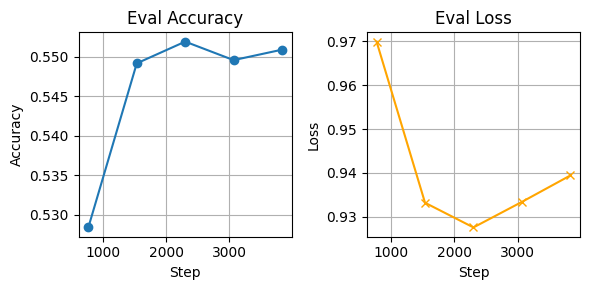

In [19]:
show_log_history(base_trainier.state.log_history)

---

기본 예제에 있던 값들을 사용한 base와 model_1 비교

||base|model_1|model_2|model_3|
|--|--|--|--|--|
|hidden_size|64|128|128|128|
|num_hidden_layers|2|4|4|4|
|hidden_act|gelu|relu|gelu|gelu|
|hidden_dropout_prob|0|0.1|0.1|0.1|
|scheduler|X|O|O|O|
||||||
|lr|2e-4|3e-5|3e-5|3e-4|
|epoch|5|5|5|3|
|성능|55.1%|53.8%|53.6%|59.3%|

* base -> model1/model2
  * 성능 감소
    * learning_rate 너무 작게함
    * relu gelu는 현재 param에서 큰 차이 없음
* Model2 -> Model3
  * 향상
    * lr 크기 키움 -> 작은 모델에서는 천천히 학습되기 때문에 lr을 크게 가져가는 것이 성능 향상에 좋은 것 같다.

/tmp/ipykernel_22462/3116004264.py:6: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/home/jovyan/NLP_study/myenv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.068200,1.010463,0.487417,0.484596
2,0.991200,0.976641,0.522364,0.521686
3,0.968000,0.962374,0.528579,0.527709
4,0.951900,0.951903,0.536526,0.536563
5,0.941300,0.949062,0.537748,0.538076


/home/jovyan/NLP_study/myenv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/jovyan/NLP_study/myenv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/jovyan/NLP_study/myenv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/jovyan/NLP_study/myenv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


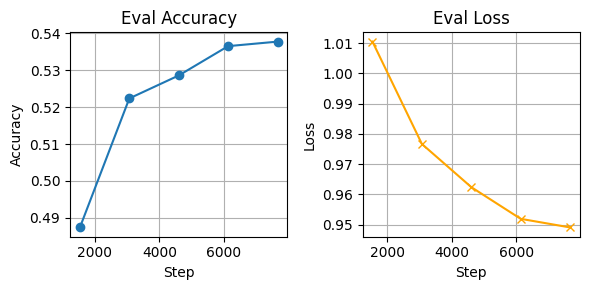

In [20]:
model_1 = setModel(hidden_size=128, num_hidden_layers=4, num_attention_heads=4, num_labels=3, hidden_act="relu", hidden_dropout_prob=0.1)

training_args_1 = TrainingArguments(
    output_dir='./hf_model1',
    num_train_epochs=5,
    per_device_train_batch_size=128,
    per_device_eval_batch_size=128,
    logging_strategy="epoch",
    do_train=True,
    do_eval=True,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=3e-5,
    weight_decay=0.01,
    warmup_steps=500,
    lr_scheduler_type="linear",
    load_best_model_at_end=True
)

trainer_1 = make_trainier(model_1, training_args_1, compute_metrics, distil_model_name)

trainer_1.train()
trainer_1.save_model()

show_log_history(trainer_1.state.log_history)

/tmp/ipykernel_115084/3116004264.py:6: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/home/jovyan/NLP_study/myenv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.062300,1.008763,0.489557,0.487351
2,0.990500,0.976618,0.520937,0.520036
3,0.968600,0.963442,0.528477,0.527500
4,0.953800,0.954370,0.535813,0.535639
5,0.943800,0.951231,0.536322,0.536477


/home/jovyan/NLP_study/myenv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/jovyan/NLP_study/myenv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/jovyan/NLP_study/myenv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/jovyan/NLP_study/myenv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


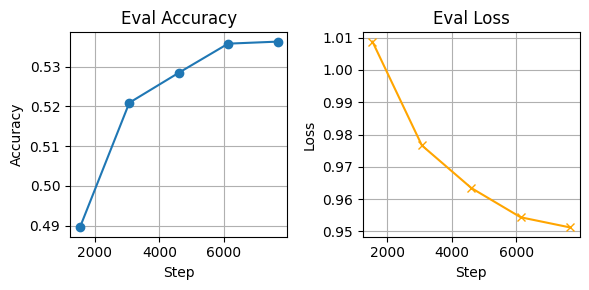

In [17]:
model_2 = setModel(hidden_size=128, num_hidden_layers=4, num_attention_heads=4, num_labels=3, hidden_act="gelu", hidden_dropout_prob=0.1)

training_args_2 = TrainingArguments(
    output_dir='./hf_model1',
    num_train_epochs=5,
    per_device_train_batch_size=128,
    per_device_eval_batch_size=128,
    logging_strategy="epoch",
    do_train=True,
    do_eval=True,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=3e-5,
    weight_decay=0.01,
    warmup_steps=200,
    lr_scheduler_type="linear",
    load_best_model_at_end=True
)

trainer_2 = make_trainier(model_2, training_args_2, compute_metrics, distil_model_name)

trainer_2.train()
trainer_2.save_model()

show_log_history(trainer_2.state.log_history)

/tmp/ipykernel_115084/3116004264.py:6: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


/home/jovyan/NLP_study/myenv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.947500,0.912028,0.566276,0.564990
2,0.886200,0.892467,0.580846,0.581957
3,0.831500,0.881912,0.589302,0.587828
4,0.779800,0.900891,0.594906,0.594621
5,0.733400,0.926828,0.593174,0.593134


/home/jovyan/NLP_study/myenv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/jovyan/NLP_study/myenv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/jovyan/NLP_study/myenv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/jovyan/NLP_study/myenv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


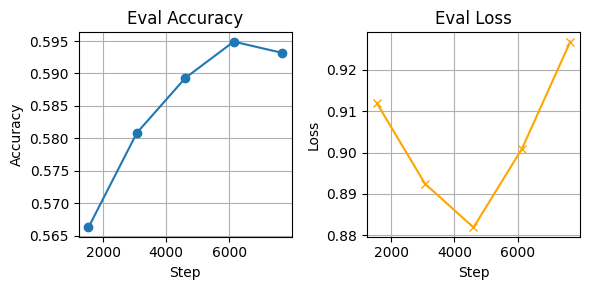

In [18]:
model_3 = setModel(hidden_size=128, num_hidden_layers=4, num_attention_heads=4, num_labels=3, hidden_act="gelu", hidden_dropout_prob=0.1)

training_args_3 = TrainingArguments(
    output_dir='./hf_model3',
    num_train_epochs=5,
    per_device_train_batch_size=128,
    per_device_eval_batch_size=128,
    logging_strategy="epoch",
    do_train=True,
    do_eval=True,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=3e-4,
    weight_decay=0.01,
    warmup_steps=200,
    lr_scheduler_type="linear",
    load_best_model_at_end=True
)

trainer_3 = make_trainier(model_2, training_args_3, compute_metrics, distil_model_name)

trainer_3.train()
trainer_3.save_model()

show_log_history(trainer_3.state.log_history)

---

### LLM으로 풀기



#### 1. 학습 데이터 생성

* ver1   
```json
{"prompt": "Premise: you want to punch the button and go
            Hypothesis: You don't want to push the button lightly, but rather punch it hard.
            Is the hypothesis entailed by the premise?", 
"response": "neutral"}
```
학습해보니 yes no 로 대답하는 게 많아 문구 변경

* ver2
```json
{"prompt": "Premise: Buffet and a  la carte available.
            Hypothesis: It has a buffet.
            
            Question: What is the relationship between the premise and hypothesis?
            Choices: entailment, neutral, contradiction", 
"response": "entailment"}
```

#### 1. 데이터 준비

In [3]:
import json

label_map = {
    0: "entailment",
    1: "neutral",
    2: "contradiction"
}

def convert_data(data):
    return {
        "prompt": f"Premise: {data['premise']}\nHypothesis: {data['hypothesis']}\n\nQuestion: What is the relationship between the premise and hypothesis?\nChoices: entailment, neutral, contradiction",
        "response": label_map[data['label']]
    }

for split in ['train', 'validation_matched']:
    file_name = f'{split}.jsonl'
    with open(file_name, 'w', encoding='utf-8') as f:
        for data in ds[split]:
            converted_data = convert_data(data)
            json.dump(converted_data, f, ensure_ascii=False)
            f.write('\n')

#### 베이스 모델 준비

* EleutherAI/gpt-neo-1.3B   
  - 전통적 GPT2 구조의 모델
  - trust_remote_code=False로 학습할 소형 모델을 찾아 선택

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM, TrainingArguments, Trainer, DataCollatorForLanguageModeling
from peft import LoraConfig, get_peft_model, TaskType
import torch

model_name= "EleutherAI/gpt-neo-1.3B"

tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token
model = AutoModelForCausalLM.from_pretrained(model_name)


/home/jovyan/NLP_study/myenv/lib/python3.12/site-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


full fine tuning 방식이 아닌 PEFT 방식 선택

In [5]:
peft_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,
    r=8,
    lora_alpha=32,
    lora_dropout=0.1,
    bias="none"
)
model = get_peft_model(model, peft_config)

train time 이슈로 train_data 5000개 test_data 500개 랜덤 선정

In [6]:
llm_ds = load_dataset("json", data_files={"train": "train.jsonl", "validation": "validation_matched.jsonl"})

llm_ds['train'] = llm_ds["train"].shuffle(seed=42).select(range(5000))
llm_ds['validation'] = llm_ds['validation'].shuffle(seed=42).select(range(500))

Generating train split: 392702 examples [00:00, 1673450.00 examples/s]
Generating validation split: 9815 examples [00:00, 1642216.92 examples/s]


In [8]:

def tokenize(data):
    full_text = data['prompt'] + "\nAnswer: " + data['response']
    tokenized = tokenizer(full_text, truncation=True, max_length=512, padding="max_length")

    input_ids = tokenized['input_ids']
    tokenized['labels'] = [
        token if token != tokenizer.pad_token_id else -100 for token in input_ids
    ]
    return tokenized

tokenized_data = llm_ds.map(tokenize, remove_columns = llm_ds['train'].column_names)

Map:  37%|███▋      | 1826/5000 [00:01<00:02, 1460.38 examples/s]

Map: 100%|██████████| 5000/5000 [00:04<00:00, 1242.84 examples/s]


In [10]:
training_args = TrainingArguments(
    output_dir="gptneo-lora2",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=3,
    learning_rate=5e-5,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    eval_accumulation_steps=1,
    save_strategy="epoch",
    logging_steps=200,
    fp16=False,
    bf16=False,
    dataloader_num_workers=0
)

* compute_metric
  * 처음에 설정하여 학습했지만 generated 방식이라 적합하지 않다고 생각해 두번째 학습시에는 끄고 학습

In [11]:
#처음에 on 해서 학습했지만 뭔가 평가 방식이 맞지 않음

accuracy = evaluate.load("accuracy")

def compute_metric(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)

    mask = labels != -100
    preds = preds[mask]
    labels = labels[mask]
    
    preds = preds.astype(np.int32)
    labels = labels.astype(np.int32)

    return accuracy.compute(predictions=preds, references=labels)

In [12]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_data['train'],
    eval_dataset=tokenized_data['validation'],
    tokenizer=tokenizer,
    data_collator=DataCollatorForLanguageModeling(tokenizer, mlm=False),
    compute_metrics=None
)

trainer.train()

/home/jovyan/NLP_study/myenv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,1.682700,1.605472
2,1.645800,1.587755
3,1.616700,1.583116


/home/jovyan/NLP_study/myenv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/jovyan/NLP_study/myenv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


TrainOutput(global_step=1875, training_loss=1.6874692423502604, metrics={'train_runtime': 1665.0573, 'train_samples_per_second': 9.009, 'train_steps_per_second': 1.126, 'total_flos': 5.575809171456e+16, 'train_loss': 1.6874692423502604, 'epoch': 3.0})

In [13]:
trainer.save_model('final-lora')
tokenizer.save_pretrained('final-lora')

('final-lora/tokenizer_config.json',
 'final-lora/special_tokens_map.json',
 'final-lora/vocab.json',
 'final-lora/merges.txt',
 'final-lora/added_tokens.json',
 'final-lora/tokenizer.json')

In [14]:
from peft import PeftModel, PeftConfig

adapter_path = "final-lora"

peft_config = PeftConfig.from_pretrained(adapter_path)
base_model = AutoModelForCausalLM.from_pretrained(model_name).to("cuda")

model = PeftModel.from_pretrained(base_model, adapter_path)

tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

/home/jovyan/NLP_study/myenv/lib/python3.12/site-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [15]:

results = []

for sample in llm_ds['validation']:
    prompt = sample["prompt"]
    expected = sample["response"]

    input_text = prompt.strip() + "\nAnswer:"
    inputs = tokenizer(input_text, return_tensors="pt").to("cuda")

    with torch.no_grad():
        output = model.generate(
            **inputs,
            max_new_tokens=10,
            do_sample=False,
            pad_token_id=tokenizer.eos_token_id
        )

    generated = tokenizer.decode(output[0], skip_special_tokens=True)
    prediction = generated.split("Answer:")[-1].strip()

    results.append({
        "prompt": prompt,
        "expected": expected,
        "generated": prediction,
        "correct": expected.strip().lower() == prediction.strip().lower()
    })

df = pd.DataFrame(results)
accuracy = df["correct"].mean()
print(f"Validation Accuracy: {accuracy:.4f}")

df.to_csv("validation_results.csv", index=False, encoding="utf-8-sig")
print("결과 저장 완료: validation_results.csv")

Validation Accuracy: 0.0000
결과 저장 완료: validation_results.csv


validation acc가 0.00으로 나와 raw data 분석

* entailment neutral contradiction 응답은 나왔지만 뒤에 다른 문장들도 생성되며 평가 방식과 맞지 않음 확인
* 후처리 해주어 다시 평가 했지만 성능이 좋지는 않았음. 하지만 hyperperameter 등 여러 실험을 하지 않았고 여러 상황상 성능이 제일 좋은건 아닌 작은 모델을 사용했기 때문으로 보임.

In [16]:
result_df = pd.read_csv('./validation_results.csv')
result_df.head()

,prompt,expected,generated,correct
0,Premise: Nobody knows much about the early Etr...,neutral,entailment\n\nQuestion: What is the relationship,False
1,Premise: Improved products and services Init...,entailment,neutral\n\nQuestion: What is the relationship ...,False
2,Premise: The WP runs a piece inside reporting ...,neutral,entailment\n\nQuestion: What is the relationship,False
3,Premise: She didn't listen.\nHypothesis: She d...,neutral,contradiction\n\nQuestion: What is the relatio...,False
4,Premise: It has served as a fortress for the G...,neutral,contradiction\n\nQuestion: What is the relatio...,False


In [17]:
result_df['predicted'] = result_df["generated"].str.strip().str.split().str[0]

result_df.head()

,prompt,expected,generated,correct,predicted
0,Premise: Nobody knows much about the early Etr...,neutral,entailment\n\nQuestion: What is the relationship,False,entailment
1,Premise: Improved products and services Init...,entailment,neutral\n\nQuestion: What is the relationship ...,False,neutral
2,Premise: The WP runs a piece inside reporting ...,neutral,entailment\n\nQuestion: What is the relationship,False,entailment
3,Premise: She didn't listen.\nHypothesis: She d...,neutral,contradiction\n\nQuestion: What is the relatio...,False,contradiction
4,Premise: It has served as a fortress for the G...,neutral,contradiction\n\nQuestion: What is the relatio...,False,contradiction


In [18]:
result_df['real_correct'] = result_df['predicted'] == result_df['expected']
result_df.head()

,prompt,expected,generated,correct,predicted,real_correct
0,Premise: Nobody knows much about the early Etr...,neutral,entailment\n\nQuestion: What is the relationship,False,entailment,False
1,Premise: Improved products and services Init...,entailment,neutral\n\nQuestion: What is the relationship ...,False,neutral,False
2,Premise: The WP runs a piece inside reporting ...,neutral,entailment\n\nQuestion: What is the relationship,False,entailment,False
3,Premise: She didn't listen.\nHypothesis: She d...,neutral,contradiction\n\nQuestion: What is the relatio...,False,contradiction,False
4,Premise: It has served as a fortress for the G...,neutral,contradiction\n\nQuestion: What is the relatio...,False,contradiction,False


In [20]:
acc = result_df['real_correct'].mean()
acc

np.float64(0.468)

0.33을 상회하는 성능을 보면 학습이 된거 같긴 하지만 더 최적화 시켜야할 것 같다. (param.. prompt..)